# ECG-Level Mortality by LOS Class

Analyze mortality rate for each ECG, grouped by LOS class.


In [9]:
# Setup
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Add project root to path
project_root = Path().resolve().parent.parent
sys.path.insert(0, str(project_root))

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11


In [10]:
# Import required modules
from src.data.ecg.ecg_loader import build_demo_index  # For WFDB .hea/.dat files
from src.data.ecg.ecg_dataset import extract_subject_id_from_path, construct_ecg_time
from src.data.ecg.ecg_metadata import extract_timestamp_from_record
from src.data.labeling import load_icustays, ICUStayMapper, los_to_bin
from typing import Dict, List
import pandas as pd
import numpy as np

# Define functions
def analyze_ecg_mortality_by_los_class(
    dataset_name: str,
    data_dir: Path,
    icustays_df: pd.DataFrame,
    admissions_df: pd.DataFrame
) -> Dict:
    """Analyze ECG mortality by LOS class.
    
    Uses ECG timestamps from WFDB files (base_date, base_time) for accurate
    ICU stay matching. Falls back to first ICU stay if timestamps unavailable.
    """
    print(f"\n{'='*80}")
    print(f"Analyzing dataset: {dataset_name}")
    print(f"{'='*80}")
    
    print(f"Scanning ECG files in: {data_dir}")
    
    # Try WFDB format first (original files), fall back to .npy if not found
    try:
        records = build_demo_index(data_dir=str(data_dir))
        print(f"Found {len(records):,} ECG files (WFDB format)")
        use_wfdb_timestamps = True
    except (FileNotFoundError, RuntimeError):
        # Fall back to .npy files if WFDB not found
        from src.data.ecg.ecg_loader import build_npy_index
        try:
            records = build_npy_index(data_dir=str(data_dir))
            print(f"Found {len(records):,} ECG files (.npy format)")
            use_wfdb_timestamps = False
        except (FileNotFoundError, RuntimeError):
            print(f"Error: No ECG files found in {data_dir}")
            return None
    
    icu_mapper = ICUStayMapper(icustays_df)
    
    admissions_with_deathtime = admissions_df[['hadm_id', 'deathtime']].copy()
    admissions_with_deathtime['deathtime'] = pd.to_datetime(
        admissions_with_deathtime['deathtime'], errors='coerce'
    )
    hadm_to_deathtime = dict(zip(
        admissions_with_deathtime['hadm_id'],
        admissions_with_deathtime['deathtime']
    ))
    
    # Check if hadm_id is available (required for mortality analysis)
    if 'hadm_id' not in icustays_df.columns:
        raise ValueError(
            "icustays_df must contain 'hadm_id' column for mortality analysis. "
            "Please reload icustays_df using the updated load_icustays() function."
        )
    
    icustays_with_info = icustays_df.copy()
    icustays_with_info['intime'] = pd.to_datetime(icustays_with_info['intime'])
    icustays_with_info['outtime'] = pd.to_datetime(icustays_with_info['outtime'])
    stay_to_info = {}
    for _, row in icustays_with_info.iterrows():
        stay_to_info[row['stay_id']] = {
            'hadm_id': row['hadm_id'],
            'intime': row['intime'],
            'outtime': row['outtime'],
            'los': row['los']
        }
    
    class_stats = {i: {'died': 0, 'survived': 0} for i in range(10)}
    matched_count = 0
    unmatched_count = 0
    
    print("\nProcessing ECGs...")
    for i, record in enumerate(records):
        if (i + 1) % 10000 == 0:
            print(f"  Processed {i + 1:,}/{len(records):,} ECGs...")
        
        base_path = record["base_path"]
        try:
            subject_id = extract_subject_id_from_path(base_path)
            subject_stays = icu_mapper.icustays_df[
                icu_mapper.icustays_df['subject_id'] == subject_id
            ]
            
            if len(subject_stays) == 0:
                unmatched_count += 1
                continue
            
            # Try to extract ECG timestamp from WFDB file
            ecg_time = None
            if use_wfdb_timestamps:
                try:
                    timestamp_info = extract_timestamp_from_record(base_path)
                    if timestamp_info['date'] and timestamp_info['time']:
                        ecg_time = construct_ecg_time(
                            timestamp_info['date'],
                            timestamp_info['time']
                        )
                except Exception:
                    pass  # Fall back to first stay if timestamp extraction fails
            
            # If no timestamp available, use first ICU stay's intime as fallback
            if ecg_time is None:
                first_stay = subject_stays.iloc[0]
                ecg_time = pd.to_datetime(first_stay['intime'])
            
            stay_id = icu_mapper.map_ecg_to_stay(subject_id, ecg_time)
            
            if stay_id is None:
                unmatched_count += 1
                continue
            
            los_days = icu_mapper.get_los(stay_id)
            if los_days is None:
                unmatched_count += 1
                continue
            
            los_class = los_to_bin(los_days)
            
            if stay_id not in stay_to_info:
                unmatched_count += 1
                continue
            
            stay_info = stay_to_info[stay_id]
            hadm_id = stay_info['hadm_id']
            intime = stay_info['intime']
            outtime = stay_info['outtime']
            
            deathtime = hadm_to_deathtime.get(hadm_id)
            died_in_this_stay = (
                deathtime is not None and
                pd.notna(deathtime) and
                intime <= deathtime <= outtime
            )
            
            if died_in_this_stay:
                class_stats[los_class]['died'] += 1
            else:
                class_stats[los_class]['survived'] += 1
            
            matched_count += 1
        except Exception:
            unmatched_count += 1
            continue
    
    print(f"\n  Matched: {matched_count:,} ECGs")
    print(f"  Unmatched: {unmatched_count:,} ECGs")
    
    results = []
    for class_idx in range(10):
        died = class_stats[class_idx]['died']
        survived = class_stats[class_idx]['survived']
        total = died + survived
        mortality_rate = (died / total * 100) if total > 0 else 0.0
        
        los_range = "[9, +inf) days" if class_idx == 9 else f"[{class_idx}, {class_idx+1}) days"
        
        results.append({
            'class': class_idx,
            'los_range': los_range,
            'total_ecgs': total,
            'died_ecgs': died,
            'survived_ecgs': survived,
            'mortality_rate': mortality_rate
        })
        
        if total > 0:
            print(f"\n  Class {class_idx} ({los_range}):")
            print(f"    Total ECGs: {total:,}")
            print(f"    Died: {died:,} ({mortality_rate:.2f}%)")
            print(f"    Survived: {survived:,} ({100 - mortality_rate:.2f}%)")
    
    return {
        'dataset_name': dataset_name,
        'total_ecgs': matched_count,
        'results_by_class': results
    }

def create_mortality_chart(results_list: List[Dict], return_figure: bool = True):
    """Create visualization: mortality rate by LOS class."""
    if len(results_list) == 0:
        print("No results to visualize.")
        return None
    
    n_classes = 10
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
    
    for result in results_list:
        dataset_name = result['dataset_name']
        results_by_class = result['results_by_class']
        classes = [r['class'] for r in results_by_class]
        mortality_rates = [r['mortality_rate'] for r in results_by_class]
        ax1.plot(classes, mortality_rates, marker='o', linewidth=2, markersize=8,
                label=dataset_name, alpha=0.8)
    
    ax1.set_xlabel('LOS Class', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Mortality Rate (%)', fontsize=12, fontweight='bold')
    ax1.set_title('ECG Mortality Rate by LOS Class', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(10))
    ax1.set_xticklabels([f'{i}' for i in range(10)])
    ax1.legend(loc='upper left')
    ax1.grid(axis='y', alpha=0.3, linestyle='--')
    ax1.set_ylim([0, None])
    
    x = np.arange(n_classes)
    width = 0.35
    for i, result in enumerate(results_list):
        dataset_name = result['dataset_name']
        results_by_class = result['results_by_class']
        mortality_rates = [r['mortality_rate'] for r in results_by_class]
        offset = width * (i - 0.5) if len(results_list) == 2 else 0
        bars = ax2.bar(x + offset, mortality_rates, width, label=dataset_name, alpha=0.8)
        for bar, rate in zip(bars, mortality_rates):
            if rate > 0:
                height = bar.get_height()
                ax2.text(bar.get_x() + bar.get_width()/2., height,
                        f'{rate:.1f}%',
                        ha='center', va='bottom', fontsize=8)
    
    ax2.set_xlabel('LOS Class', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Mortality Rate (%)', fontsize=12, fontweight='bold')
    ax2.set_title('ECG Mortality Rate by LOS Class (Grouped)', fontsize=14, fontweight='bold')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'{i}' for i in range(10)])
    ax2.legend(loc='upper left')
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.set_ylim([0, None])
    
    plt.tight_layout()
    return fig


In [11]:
# Load data
# Use absolute paths relative to project root
icustays_path = project_root / "data/labeling/labels_csv/icustays.csv"
admissions_path = project_root / "data/labeling/labels_csv/admissions.csv"

print(f"Loading ICU stays from: {icustays_path}")
print(f"Loading admissions from: {admissions_path}")

if not icustays_path.exists():
    raise FileNotFoundError(f"ICU stays file not found: {icustays_path}")
if not admissions_path.exists():
    raise FileNotFoundError(f"Admissions file not found: {admissions_path}")

# Reload the module to ensure we have the latest version
import importlib
from src.data.labeling import icu_los_labels
importlib.reload(icu_los_labels)
from src.data.labeling.icu_los_labels import load_icustays

icustays_df = load_icustays(str(icustays_path))
admissions_df = pd.read_csv(str(admissions_path))

print(f"Loaded {len(icustays_df):,} ICU stays")
print(f"Loaded {len(admissions_df):,} admissions")

# Verify hadm_id is present
if 'hadm_id' not in icustays_df.columns:
    print("WARNING: hadm_id column not found in icustays_df. Mortality analysis may fail.")
    print(f"Available columns: {list(icustays_df.columns)}")
else:
    print(f"✓ hadm_id column found in icustays_df")


Loading ICU stays from: /pfs/data6/home/ka/ka_aifb/ka_zx9981/workspace/ma-thesis/MA-thesis-1/data/labeling/labels_csv/icustays.csv
Loading admissions from: /pfs/data6/home/ka/ka_aifb/ka_zx9981/workspace/ma-thesis/MA-thesis-1/data/labeling/labels_csv/admissions.csv
Loaded 94,458 ICU stays
Loaded 546,028 admissions
✓ hadm_id column found in icustays_df


In [12]:
# Analyze both datasets
# Using original WFDB files (.hea/.dat) from 'original' subdirectories
# Use absolute paths relative to project root
datasets = {
    'all_icu_ecgs': {
        'name': 'All ICU ECGs',
        'data_dir': project_root / 'data/all_icu_ecgs/original'
    },
    'icu_24h': {
        'name': 'ICU 24h',
        'data_dir': project_root / 'data/icu_ecgs_24h/original'
    }
}

results_list = []
for dataset_key, dataset_info in datasets.items():
    if dataset_info['data_dir'].exists():
        result = analyze_ecg_mortality_by_los_class(
            dataset_name=dataset_info['name'],
            data_dir=dataset_info['data_dir'],
            icustays_df=icustays_df,
            admissions_df=admissions_df
        )
        if result:
            results_list.append(result)
    else:
        print(f"Dataset {dataset_info['name']} not found at {dataset_info['data_dir']}")



Analyzing dataset: All ICU ECGs
Scanning ECG files in: /pfs/data6/home/ka/ka_aifb/ka_zx9981/workspace/ma-thesis/MA-thesis-1/data/all_icu_ecgs/original
Found 61,663 ECG files (WFDB format)

Processing ECGs...
  Processed 10,000/61,663 ECGs...
  Processed 20,000/61,663 ECGs...
  Processed 30,000/61,663 ECGs...
  Processed 40,000/61,663 ECGs...
  Processed 50,000/61,663 ECGs...
  Processed 60,000/61,663 ECGs...

  Matched: 61,600 ECGs
  Unmatched: 63 ECGs

  Class 0 ([0, 1) days):
    Total ECGs: 4,742
    Died: 368 (7.76%)
    Survived: 4,374 (92.24%)

  Class 1 ([1, 2) days):
    Total ECGs: 12,641
    Died: 567 (4.49%)
    Survived: 12,074 (95.51%)

  Class 2 ([2, 3) days):
    Total ECGs: 9,025
    Died: 554 (6.14%)
    Survived: 8,471 (93.86%)

  Class 3 ([3, 4) days):
    Total ECGs: 6,477
    Died: 468 (7.23%)
    Survived: 6,009 (92.77%)

  Class 4 ([4, 5) days):
    Total ECGs: 4,665
    Died: 477 (10.23%)
    Survived: 4,188 (89.77%)

  Class 5 ([5, 6) days):
    Total ECGs: 3,

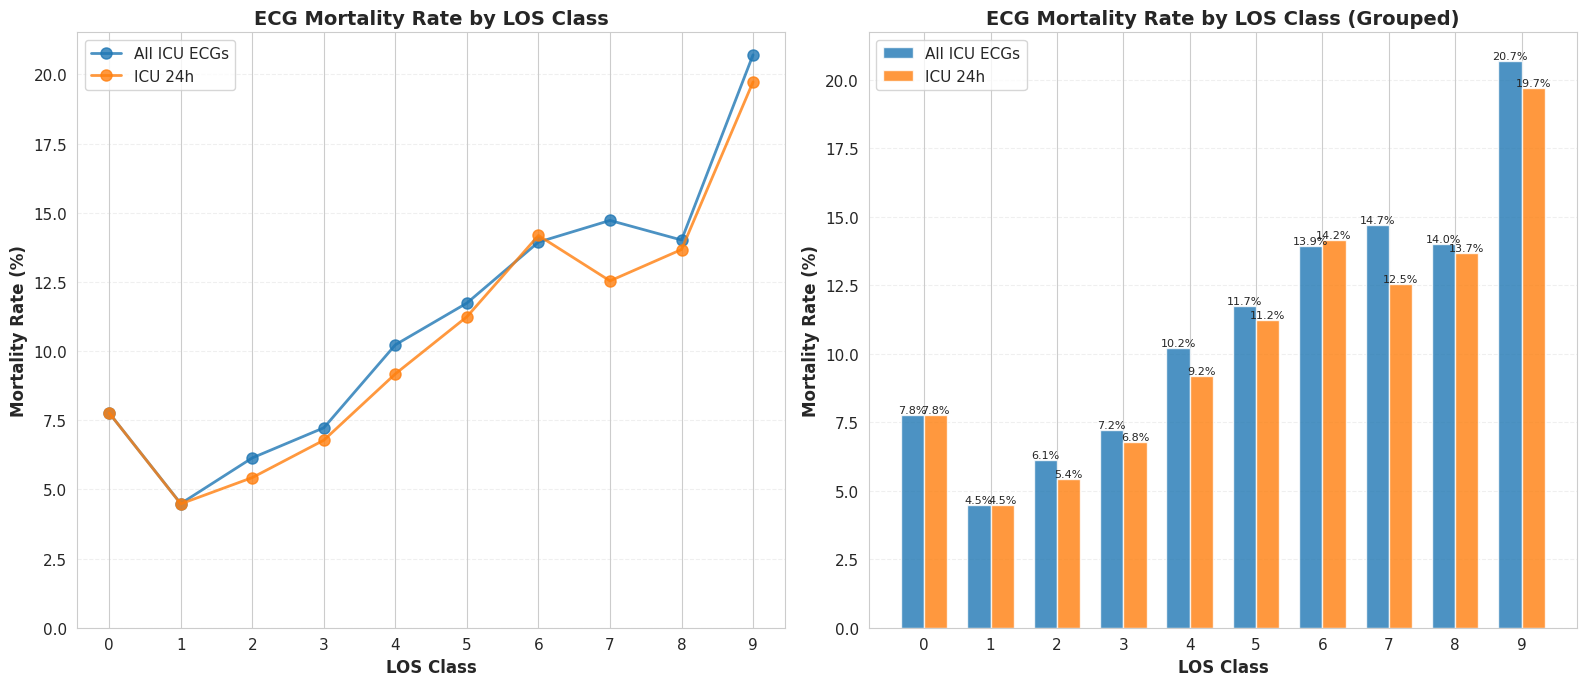


DETAILED RESULTS BY LOS CLASS

All ICU ECGs:
 class      los_range  total_ecgs  died_ecgs  survived_ecgs  mortality_rate
     0    [0, 1) days        4742        368           4374        7.760439
     1    [1, 2) days       12641        567          12074        4.485405
     2    [2, 3) days        9025        554           8471        6.138504
     3    [3, 4) days        6477        468           6009        7.225567
     4    [4, 5) days        4665        477           4188       10.225080
     5    [5, 6) days        3358        394           2964       11.733175
     6    [6, 7) days        2655        370           2285       13.935970
     7    [7, 8) days        2140        315           1825       14.719626
     8    [8, 9) days        1877        263           1614       14.011721
     9 [9, +inf) days       14020       2903          11117       20.706134

ICU 24h:
 class      los_range  total_ecgs  died_ecgs  survived_ecgs  mortality_rate
     0    [0, 1) days        474

In [13]:
# Visualize results
if results_list:
    # Create chart (display inline in notebook)
    fig = create_mortality_chart(results_list, return_figure=True)
    plt.show()
    
    # Display results table
    print("\n" + "="*80)
    print("DETAILED RESULTS BY LOS CLASS")
    print("="*80)
    
    for result in results_list:
        print(f"\n{result['dataset_name']}:")
        df = pd.DataFrame(result['results_by_class'])
        print(df.to_string(index=False))
